<a href="https://colab.research.google.com/github/Adarsh-Vemali/Numerical_linear_algebra/blob/main/SOTA_GCN_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Adarsh-Vemali/Numerical_linear_algebra

Cloning into 'Numerical_linear_algebra'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 22), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (65/65), 5.33 MiB | 4.20 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [2]:
!pip3 install -r /content/Numerical_linear_algebra/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.1/573.1 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.4 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import sys

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
def uniform(shape, scale=0.05, name=None):
    """Uniform init."""
    initial = tf.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def glorot(shape, name=None):
    """Glorot & Bengio (AISTATS 2010) init."""
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = tf.random_uniform(shape, minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def zeros(shape, name=None):
    """All zeros."""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def ones(shape, name=None):
    """All ones."""
    initial = tf.ones(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

In [7]:
def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_data(dataset_str, basedir=''):
    """
    Loads input data from gcn/data directory

    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.

    All objects above must be saved using python pickle module.

    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []

    # Read data as pickle objects
    for i in range(len(names)):
        with open(basedir+"data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    # Get individual variables from objects
    x, y, tx, ty, allx, ally, graph = tuple(objects)

    # Get test indices
    test_idx_reorder = parse_index_file(basedir+"data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    # Get feature vector and adjacency matrix
    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    # Get labels
    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    # Generate train, val test split
    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    # Masks to identify train-val-test data points
    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask

In [8]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data('cora', '/content/Numerical_linear_algebra/')

<ipython-input-7-eb1974212742>:43: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  objects.append(pkl.load(f, encoding='latin1'))
<ipython-input-7-eb1974212742>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(mask, dtype=np.bool)


In [9]:
def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    # If list of sparse_mx are passed, convert each of them to tuple form
    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict

In [10]:
# Preprocess Feature and Adjacency Matrices
features = preprocess_features(features)
support = [preprocess_adj(adj)]

In [11]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# global unique layer ID dictionary for layer name assignment
_LAYER_UIDS = {}


def get_layer_uid(layer_name=''):
    """Helper function, assigns unique layer IDs."""
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]


def sparse_dropout(x, keep_prob, noise_shape):
    """Dropout for sparse tensors."""
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)


def dot(x, y, sparse=False):
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
        res = tf.sparse_tensor_dense_matmul(x, y)
    else:
        res = tf.matmul(x, y)
    return res


class Layer(object):
    """Base layer class. Defines basic API for all layer objects.
    Implementation inspired by keras (http://keras.io).

    # Properties
        name: String, defines the variable scope of the layer.
        logging: Boolean, switches Tensorflow histogram logging on/off

    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
        _log_vars(): Log all variables
    """

    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' + str(get_layer_uid(layer))
        self.name = name
        self.vars = {}
        logging = kwargs.get('logging', False)
        self.logging = logging
        self.sparse_inputs = False

    def _call(self, inputs):
        return inputs

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            if self.logging and not self.sparse_inputs:
                tf.summary.histogram(self.name + '/inputs', inputs)
            outputs = self._call(inputs)
            if self.logging:
                tf.summary.histogram(self.name + '/outputs', outputs)
            return outputs

    def _log_vars(self):
        for var in self.vars:
            tf.summary.histogram(self.name + '/vars/' + var, self.vars[var])


class Dense(Layer):
    """Dense layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0., sparse_inputs=False,
                 act=tf.nn.relu, bias=False, featureless=False, **kwargs):
        super(Dense, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = glorot([input_dim, output_dim],
                                          name='weights')
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # transform
        output = dot(x, self.vars['weights'], sparse=self.sparse_inputs)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)


class GraphConvolution(Layer):
    """Graph convolution layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0.,
                 sparse_inputs=False, act=tf.nn.relu, bias=False,
                 featureless=False, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)

        # Add dropout
        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.support = placeholders['support']
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            for i in range(len(self.support)):
                self.vars['weights_' + str(i)] = glorot([input_dim, output_dim],
                                                        name='weights_' + str(i))
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # convolve
        supports = list()
        for i in range(len(self.support)):
            # Add feature vector and weight matrix
            if not self.featureless:
                pre_sup = dot(x, self.vars['weights_' + str(i)],
                              sparse=self.sparse_inputs)
            else:
                pre_sup = self.vars['weights_' + str(i)]
            # Take into account node's neighborhood through dot product with augmented adjacency matrix i.e. support
            support = dot(self.support[i], pre_sup, sparse=True)
            supports.append(support)
        output = tf.add_n(supports)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)

In [12]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking. This takes into account the train-val-test splits via masks and calculates metric only where mask is 1"""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)


def masked_accuracy(preds, labels, mask):
    """Accuracy with masking. Similar to above function, calculates metric taking into account the data split"""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [13]:
class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}
        self.placeholders = {}

        self.layers = []
        self.activations = []

        self.inputs = None
        self.outputs = None

        self.loss = 0
        self.accuracy = 0
        self.optimizer = None
        self.opt_op = None

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.variable_scope(self.name):
            self._build()

        # Build sequential layer model
        self.activations.append(self.inputs)
        for layer in self.layers:
            hidden = layer(self.activations[-1])
            self.activations.append(hidden)
        self.outputs = self.activations[-1]

        # Store model variables for easy access
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

        # Build metrics
        self._loss()
        self._accuracy()

        self.opt_op = self.optimizer.minimize(self.loss)

    def predict(self):
        pass

    def _loss(self):
        raise NotImplementedError

    def _accuracy(self):
        raise NotImplementedError

    def save(self, sess=None, basedirpath=''):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = saver.save(sess, basedirpath+"tmp/%s.ckpt" % self.name)
        print("Model saved in file: %s" % save_path)

    def load(self, sess=None, basedirpath=''):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = basedirpath+"tmp/%s.ckpt" % self.name
        saver.restore(sess, save_path)
        print("Model restored from file: %s" % save_path)


class GCN(Model):
    def __init__(self, placeholders, input_dim, weight_decay, hidden1, learning_rate, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders
        self.weightdecay = weight_decay
        self.hidden1 = hidden1

        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += self.weightdecay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        # 1st hidden state
        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=self.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        # 2nd hidden state
        self.layers.append(GraphConvolution(input_dim=self.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        # Output the last hidden state with softmax transformation
        return tf.nn.softmax(self.outputs)

In [14]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Setting  Model Hyperparameters
FLAGS = {}
FLAGS['learning_rate'] = 0.01
FLAGS['epochs'] = 200
FLAGS['hidden1'] = 16
FLAGS['dropout'] = 0.5
FLAGS['weight_decay'] = 5e-4
FLAGS['early_stopping'] = 10
FLAGS['max_degree'] = 3


In [15]:
num_supports = 1
model_func = GCN

In [16]:
# Placeholders to define network
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

In [17]:
model = model_func(placeholders, input_dim=features[2][1], weight_decay=FLAGS['weight_decay'], hidden1=FLAGS['hidden1'], learning_rate=FLAGS['learning_rate'], logging=True)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [18]:
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)


# Init variables
sess.run(tf.global_variables_initializer())

training_curves = []

In [19]:
t1 = time.time()
for epoch in range(FLAGS['epochs']):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS['dropout']})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t), flush=True)

    training_curves.append((outs[1], outs[2], cost, acc)) # train_loss, train_acc, val_loss, val_acc

    # Stop training if early stopping criteria is reached
    if epoch > FLAGS['early_stopping'] and training_curves[-1][2] > np.mean([x[2] for x in training_curves][-(FLAGS['early_stopping']+1):-1]):
        print("Early stopping...")
        break

t2 = time.time()
print(t2-t1)
print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95398 train_acc= 0.14286 val_loss= 1.94916 val_acc= 0.19200 time= 2.62864
Epoch: 0002 train_loss= 1.94717 train_acc= 0.24286 val_loss= 1.94463 val_acc= 0.25400 time= 0.01337
Epoch: 0003 train_loss= 1.93999 train_acc= 0.40000 val_loss= 1.93989 val_acc= 0.36000 time= 0.01235
Epoch: 0004 train_loss= 1.92993 train_acc= 0.60714 val_loss= 1.93522 val_acc= 0.38400 time= 0.01087
Epoch: 0005 train_loss= 1.92239 train_acc= 0.62143 val_loss= 1.93089 val_acc= 0.38400 time= 0.01059
Epoch: 0006 train_loss= 1.91587 train_acc= 0.62143 val_loss= 1.92688 val_acc= 0.38800 time= 0.01154
Epoch: 0007 train_loss= 1.90422 train_acc= 0.65714 val_loss= 1.92295 val_acc= 0.38800 time= 0.01633
Epoch: 0008 train_loss= 1.90035 train_acc= 0.60714 val_loss= 1.91907 val_acc= 0.37200 time= 0.01155
Epoch: 0009 train_loss= 1.88919 train_acc= 0.61429 val_loss= 1.91513 val_acc= 0.37200 time= 0.01079
Epoch: 0010 train_loss= 1.88187 train_acc= 0.62143 val_loss= 1.91109 val_acc= 0.36800 time= 0.01847


In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

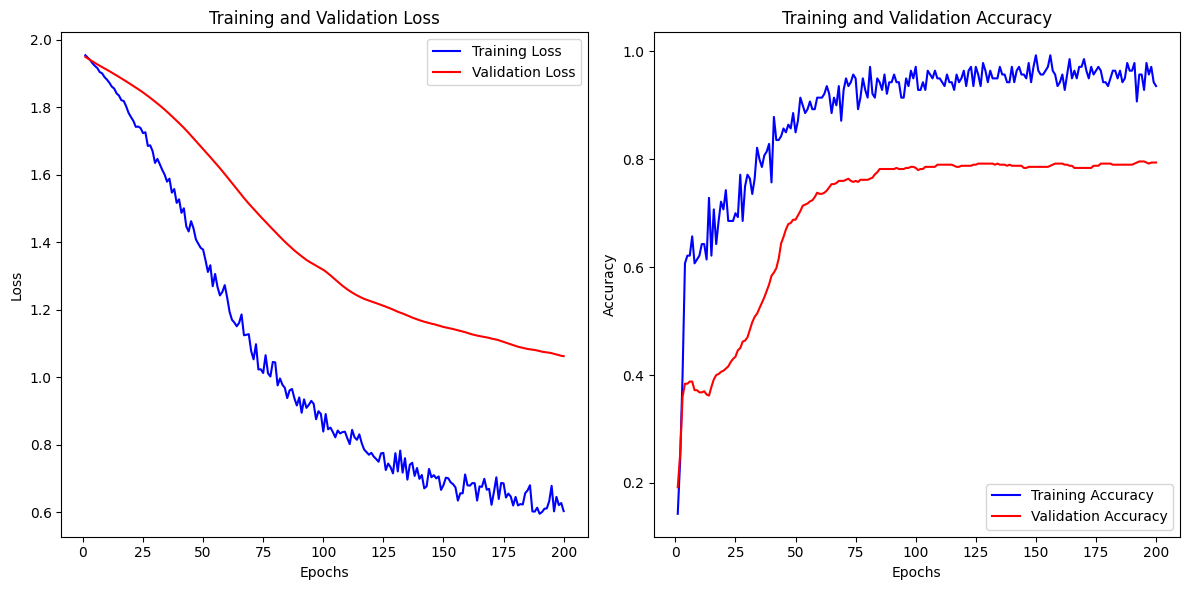

In [35]:
# List of Epochs
epochs = range(1, FLAGS['epochs'] + 1)

# Loss list
train_loss = [x[0] for x in training_curves]
val_loss = [x[2] for x in training_curves]

# Accuracy List
train_acc = [x[1] for x in training_curves]
val_acc = [x[3] for x in training_curves]

# Plotting loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
your_feed_dict = construct_feed_dict(features, support, y_test, test_mask, placeholders)

# Assuming `model` is an instance of your GCN model
# Assuming `sess` is your TensorFlow session

# Get the node embeddings
node_embeddings = sess.run(model.activations[-2], feed_dict=your_feed_dict)

In [22]:
# Assuming `true_labels` is a NumPy array with labels for each node
# You can use these labels to color the points in the plot
true_labels = sess.run(model.placeholders['labels'], feed_dict=your_feed_dict)

In [23]:
node_embeddings = np.array([node_embeddings[i] for i in range(node_embeddings.shape[0]) if test_mask[i]])
node_embeddings.shape

(1000, 16)

In [24]:
true_labels = np.array([true_labels[i] for i in range(true_labels.shape[0]) if test_mask[i]])
true_labels.shape

(1000, 7)

In [30]:
# Calculate predictions
predictions = sess.run(model.predict(), feed_dict=your_feed_dict)
predictions = np.array([predictions[i] for i in range(predictions.shape[0]) if test_mask[i]])
predictions.shape

(1000, 7)

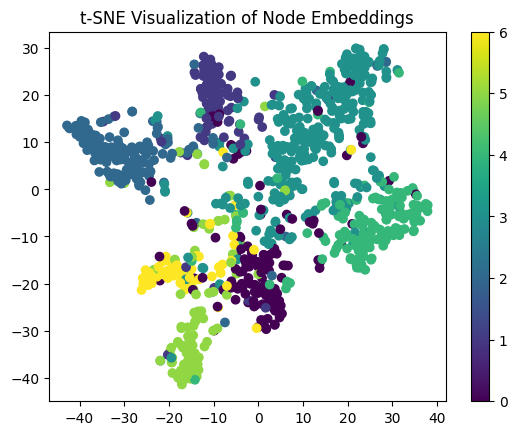

In [31]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings)

# Plot the 2D embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=np.argmax(true_labels, axis=1), cmap='viridis')
plt.title('t-SNE Visualization of Node Embeddings')
plt.colorbar()
plt.show()


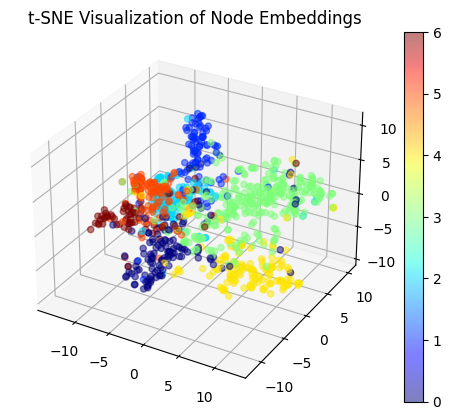

In [33]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(node_embeddings)

# Plot the 3D embeddings
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=np.argmax(true_labels, axis=1), cmap='jet', alpha=0.5)
ax.set_title('t-SNE Visualization of Node Embeddings')
fig.colorbar(scatter)
plt.show()


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Assuming `true` and `pred` are your true labels and predicted probabilities, respectively
true_labels = np.argmax(true_labels, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Accuracy: {:.4f}".format(accuracy))

Precision: 0.8309
Recall: 0.8180
F1-score: 0.8201
Accuracy: 0.8180
